In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
print(tf.__version__)

1.1.0


In [2]:
def drawErrorValues(epoch_list, train_error_value_list, validation_error_value_list, test_error_value_list):
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(epoch_list, train_error_value_list, 'r', label='Train')
    plt.plot(epoch_list, validation_error_value_list, 'g', label='Validation')
    plt.ylabel('Total Error')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(epoch_list, test_error_value_list, 'b', label='Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.yticks(np.arange(min(test_error_value_list), max(test_error_value_list), 100))
    plt.grid(True)
    plt.legend(loc='lower right')            
    plt.show()

In [3]:
class RNN:
    def __init__(self, session, batch_size, n_steps, n_inputs, n_state_units, n_classes):
        self.session = session
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_state_units = n_state_units
        self.n_classes = n_classes
        
    def set_data(self, train_data, val_data, test_data):
        self.train      = train_data
        self.validation = val_data
        self.test       = test_data
        
    def make_rnn(self, learning_rate):
        self.x = tf.placeholder(tf.float32, [None, self.n_steps, self.n_inputs])
        self.xt = tf.transpose(self.x, perm = [1, 0, 2])
        self.xr = tf.reshape(self.xt, shape = [-1, self.n_inputs])
        self.xs = tf.split(value=self.xr, num_or_size_splits=self.n_steps, axis=0)
        self.y = tf.placeholder(tf.float32, [None, n_classes])
        
        self.real_batch_size = tf.placeholder(tf.int32)
        
        self.rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units = n_state_units)
        self.initial_state = self.rnn_cell.zero_state(batch_size=self.real_batch_size, dtype=tf.float32)
        self.outputs, self.final_state = tf.contrib.rnn.static_rnn(self.rnn_cell, 
                                                                   self.xs, 
                                                                   initial_state=self.initial_state, 
                                                                   dtype=tf.float32)
        
        self.W2 = tf.Variable(tf.random_normal([self.n_state_units, self.n_classes]))
        self.B = tf.Variable(tf.random_normal([self.n_classes]))

        self.pred = tf.matmul(self.outputs[-1], self.W2) + self.B
        self.error = tf.reduce_sum(tf.square(self.pred - self.y), axis=0)
        self.optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(self.error)
   
    def learning(self, max_training_epochs):
        init = tf.global_variables_initializer()
        session.run(init)
        
        epoch_list                  = []
        train_error_value_list      = []
        validation_error_value_list = []
        test_error_value_list       = []
        test_accuracy_list          = []

        print("batch_size", self.batch_size)
        total_batch = int(math.ceil(len(self.train['x']) / float(self.batch_size)))
        print("Total batch: {0}".format(total_batch))

        for epoch in range(max_training_epochs):
            for i in range(total_batch):
                batch_x = self.train['x'][i * self.batch_size: (i+1) * self.batch_size]
                batch_y = self.train['y'][i * self.batch_size: (i+1) * self.batch_size]
                self.session.run((self.optimizer, self.error), feed_dict={
                    self.x: batch_x, 
                    self.y: batch_y,
                    self.real_batch_size: len(batch_x)
                })

            epoch_list.append(epoch)

            t_error_value = self.session.run(self.error, feed_dict={
                self.x: self.train['x'], 
                self.y: self.train['y'],
                self.real_batch_size: len(self.train['x'])
            })
            train_error_value_list.append(t_error_value)

            v_error_value = self.session.run(self.error, feed_dict={
                self.x: self.validation['x'], 
                self.y: self.validation['y'],
                self.real_batch_size: len(self.validation['x'])
            })
            validation_error_value_list.append(v_error_value)

            pred_value, test_error_value = self.session.run([self.pred, self.error], feed_dict={
                self.x: self.test['x'], 
                self.y: self.test['y'],
                self.real_batch_size: len(self.test['x'])                 
            })
            test_error_value_list.append(test_error_value)

            if (epoch % 100 == 0):
               print("epoch: {0}, test_error_value: {1}".format(epoch, test_error_value))

        print("Train completed!")
        drawErrorValues(epoch_list, train_error_value_list, validation_error_value_list, test_error_value_list)
    
    def saveModel(self, path='./rnn_sine_model.ckpt'):
        src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        tf.train.Saver(src_vars).save(self.session, path)
        print("Model saved successfully!")
        
    def get_final_test_pred(self, data_x):
        pred = self.session.run(self.pred, feed_dict={
            self.x: data_x,
            self.real_batch_size: len(data_x)    
        })
        return pred

In [4]:
def split_data(data, val_size=0.1, test_size=0.2):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data) * (1 - (val_size + test_size))))

    train_data, val_data, test_data = data[:nval], data[nval:ntest], data[ntest:]
    return train_data, val_data, test_data

def prepare_data(data, n_steps):
    x = []
    y = []
    for i in range(len(data) - n_steps - 1):
        x_item = []
        for j in range(n_steps):
            x_item.append([data[i + j]])
        x.append(x_item)
        y.append([data[i + n_steps]])
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y    

def generate_data(func, x, n_steps):
    """
    generates data with based on a function fct
    creates new data frame based on previous observation
       * example:
        l = [1, 2, 3, 4, 5]
        n_steps = 3
        -> [[[1], [2], [3]], [[2], [3], [4]], [[3], [4], [5]]]
    """
    data = func(x)
    train_data, val_data, test_data = split_data(data, val_size=0.1, test_size=0.2)
    train = {}
    val = {}
    test = {}
    train['x'], train['y'] = prepare_data(train_data, n_steps)
    val['x'], val['y'] = prepare_data(val_data, n_steps)
    test['x'], test['y'] = prepare_data(test_data, n_steps)
    return train, val, test

batch_size 128
Total batch: 547
epoch: 0, test_error_value: [ 330.21084595]
Train completed!


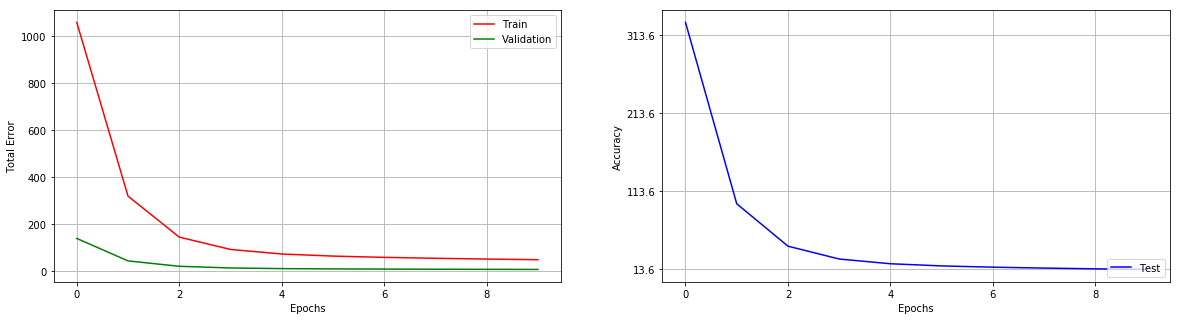

Model saved successfully!


In [5]:
batch_size = 128
n_steps = 10
n_inputs = 1
n_state_units = 4
n_classes = 1
learning_rate = 0.01
max_training_epochs = 10

if __name__ == '__main__':
    with tf.Session() as session:   
        rnn = RNN(session, batch_size, n_steps, n_inputs, n_state_units, n_classes)
        train, val, test = generate_data(np.sin, np.linspace(0, 100, 100000), n_steps)
        rnn.set_data(train, val, test)
        rnn.make_rnn(learning_rate)
        rnn.learning(max_training_epochs)
        rnn.saveModel()